In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# mostrar todo el dataframe
pd.set_option('display.max_columns', None)

# Herramientas
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.dataprocessing.transformers import Scaler

import sys
import numbers
import time
import math
import datetime as dt
from functools import reduce
import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest


In [20]:
InicioHistoricos = '2010-12' 
FinProyeccion = '2019-12' 

RutaNProyecciones = ("./Datos/")

c = "Imports"

Pig_crop = pd.read_csv(RutaNProyecciones + r"Proyeccion_PigCrop.csv")
corn =  pd.read_csv(RutaNProyecciones + r"Proyeccion_CornCost.csv")
Slaugther = pd.read_csv(RutaNProyecciones + "Proyeccion_Slaugther.csv")
Production = pd.read_csv(RutaNProyecciones + "Proyeccion_Production.csv")
Stocks = pd.read_csv(RutaNProyecciones + "Proyeccion_Stocks.csv")
Exports = pd.read_csv(RutaNProyecciones + "Proyeccion_TotalExports.csv")
ChinaExports = pd.read_csv(RutaNProyecciones + "Proyeccion_ChinaExports.csv")
MexicoExports = pd.read_csv(RutaNProyecciones + "Proyeccion_MexicoExports.csv")
CanadaExports = pd.read_csv(RutaNProyecciones + "Proyeccion_CanadaExports.csv")
KoreaExports = pd.read_csv(RutaNProyecciones + "Proyeccion_KoreaExports.csv")

ProduccionChina = pd.read_csv(RutaNProyecciones + "DatosManuales\ChinaPigPopulation.csv")
#ProduccionChina.drop(columns = ['Unnamed: 3','Unnamed: 4'],inplace = True)
ProduccionChina.set_index("Date",inplace = True)
ProduccionChina = ProduccionChina.loc[ProduccionChina.index <= FinProyeccion]
ProduccionChina.reset_index(inplace = True)

# Cargar variables independientes, empezando por el clima
indep =  pd.read_csv(RutaNProyecciones + "TemperaturaPrecipitacionProyectada.csv")
enso = pd.read_csv(RutaNProyecciones + "Proyeccion_ENSO.csv")
CornFutures = pd.read_csv(RutaNProyecciones + "Proyeccion_CornFutures.csv")
CornContinuos = pd.read_csv(RutaNProyecciones + "Proyeccion_CBOT Corn Continuous Frnt-Month Futures.csv")

dummy = pd.read_csv(RutaNProyecciones + "DatosManuales\Variables_Dummy.csv")
del dummy ["Date"]

indep = indep.merge(enso.iloc[:, 2::],how='left',left_index=True,right_index=True)
indep = indep.merge(CornFutures.iloc[:, 1::],how='left',left_index=True,right_index=True)
indep = indep.merge(CornContinuos.iloc[:, 1::],how='left',left_index=True,right_index=True)
#indep = indep.merge(dummy,how='left',left_index=True,right_index=True)

indep["CornCost"] = corn["Proyeccion"]
indep["PigCrop"] = Pig_crop["Proyeccion"]
indep["Slaugther"] = Slaugther["Proyeccion"]
#indep["Slaugther ^2"] = Slaugther["Proyeccion"]**2
indep["Production"] = Production["Proyeccion"]
indep["ColdStorageStocks"] = Stocks["Proyeccion"]
indep["PigPopulationChina"] = ProduccionChina['China Pigs']
indep["TotalExports"] = Exports["Proyeccion"]
indep["ChinaExports"] = ChinaExports["Proyeccion"]
indep["MexicoExports"] = MexicoExports["Proyeccion"]
indep["CanadaExports"] = CanadaExports["Proyeccion"]
indep["KoreaExports"] = KoreaExports["Proyeccion"]

#generar dummys de Fecha
indep["Date"] = pd.to_datetime(indep["Date"],format='%Y-%m')
date = pd.DataFrame()
date["Period"] = indep["Date"]
date['Month']=date['Period'].dt.strftime('%m')
date = pd.get_dummies(date['Month'])

#Generar dummy dependiendo estacion
date["Winter"] = date["01"] + date["02"] + date["12"]
date["Spring"] = date["03"] + date["04"] + date["05"]
date["Summer"] = date["06"] + date["07"] + date["08"]
date["Fall"] = date["09"] + date["10"] + date["11"]

date.rename(columns = {"01":"Enero","02":"Febrero","03":"Marzo","04":"Abril","05":"Mayo","06":"Junio","07":"Julio","08":"Agosto","09":"Septiembre","10":"Octubre","11":"Noviembre","12":"Diciembre"},inplace = True)
indep = indep.merge(date,how='left',left_index=True,right_index=True)

indep.set_index("Date",inplace = True)
indep = indep.loc[indep.index <= FinProyeccion]
indep.reset_index(inplace = True)

indep.describe()
indep

,Date,UM Temperature,UM Precipitation,SE Temperature,SE Precipitation,OV Temperature,OV Precipitation,S Temperature,S Precipitation,Niño,Niña,neutro,CornFutures,CBOT Corn Continuous Frnt-Month Futures,CornCost,PigCrop,Slaugther,Production,ColdStorageStocks,PigPopulationChina,TotalExports,ChinaExports,MexicoExports,CanadaExports,KoreaExports,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Winter,Spring,Summer,Fall
0,2011-01-01,11.5,1.08,41.8,3.00,26.6,1.70,40.4,1.75,0,1,0,651.00,635.12,4.94,28.300000,9104.4,1896.2,475.829,535.000000,368694.210445,25879.118754,100081.803391,29927.915370,35180.942128,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2011-02-01,18.3,1.13,50.5,2.80,34.4,3.92,44.8,1.45,0,1,0,711.50,690.45,5.65,28.400000,8506.0,1768.1,538.754,540.000000,388776.514632,23810.780886,80638.800141,32703.367055,50291.417272,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2011-03-01,28.3,1.75,56.4,5.67,44.2,4.35,56.9,1.54,0,1,0,693.25,683.74,5.53,28.500000,9872.5,2054.4,574.236,520.000000,490261.998329,33328.114990,88765.543834,42791.050600,86873.111127,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2011-04-01,43.0,3.79,65.3,3.52,55.7,8.72,66.2,2.77,0,1,0,729.00,753.10,6.36,28.400000,8628.8,1790.7,574.398,550.000000,421315.838072,24197.883717,66153.793490,42088.832408,61375.180446,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2011-05-01,55.2,4.12,70.5,2.31,63.0,5.98,70.6,2.86,0,1,0,758.75,722.17,6.32,28.300000,8542.6,1759.7,549.279,570.000000,405775.351991,23690.550304,91409.249550,40377.894672,30150.776042,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2019-08-01,66.5,3.22,79.6,5.43,74.0,4.30,83.1,3.60,0,0,1,359.75,376.59,3.93,33.333333,10865.5,2257.9,611.692,257.943356,508579.774953,93242.992249,137289.314705,43458.501316,42407.200818,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
104,2019-09-01,62.8,6.13,78.1,1.49,73.0,2.29,80.2,2.17,0,0,1,372.00,362.19,3.80,33.000000,10644.4,2237.1,606.784,250.205055,465218.269358,67677.504653,125941.450585,50438.997296,33779.634891,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
105,2019-10-01,45.2,4.79,68.7,5.48,56.6,5.26,62.2,4.37,0,0,1,390.25,389.77,3.85,33.400000,12302.5,2606.4,598.750,248.703825,521246.205145,94828.987748,119076.864245,45962.661427,47254.508655,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
106,2019-11-01,29.0,1.77,52.3,2.89,39.2,3.14,49.7,1.86,0,0,1,365.75,373.62,3.68,33.800000,11331.4,2428.6,611.916,253.677902,623442.336579,156758.042301,128755.099699,53098.551988,56294.893447,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [21]:
# Variable objetivo
imports = pd.read_excel( RutaNProyecciones + r"USA_Entities.xlsx",sheet_name='Imports')
imports["index"] = pd.to_datetime(imports["index"],format='%Y-%m')
imports.set_index("index",inplace = True)
imports = imports.loc[imports.index > InicioHistoricos]
imports = imports.loc[imports.index <= FinProyeccion]
imports.rename({'Total\n ':c}, axis='columns',inplace = True)

imports.reset_index(inplace = True)
imports

,index,Imports
0,2011-01-01,63707.907633
1,2011-02-01,60458.493677
2,2011-03-01,76801.928406
3,2011-04-01,68157.230071
4,2011-05-01,64500.254250
...,...,...
103,2019-08-01,78892.094079
104,2019-09-01,73918.938092
105,2019-10-01,81972.813712
106,2019-11-01,75365.228568


seasonal? True
There is seasonality of order 12.


Text(0.5, 1.0, 'Variable objetivo')

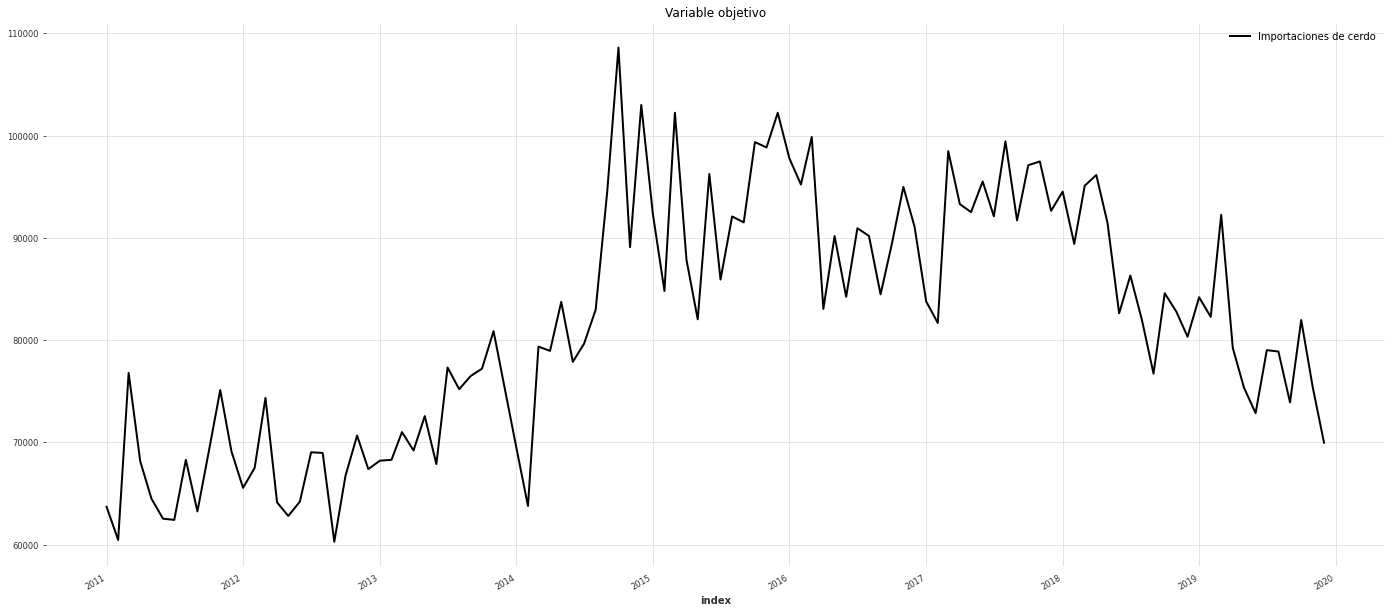

In [23]:
# Exploracion de la señal
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

# convertir dataframe en TimeSeries, specifying the time and value columns
target = TimeSeries.from_dataframe(imports,'index','Imports')
externos =  TimeSeries.from_dataframe(indep,'Date')


# Imputar datos
# replace 0 and NaN by backfilling
s = target.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
target = target.from_series(s)

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(target, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

# Graficar
plt.figure(figsize=(24, 10))
target.plot(label='Importaciones de cerdo')
plt.title("Variable objetivo")



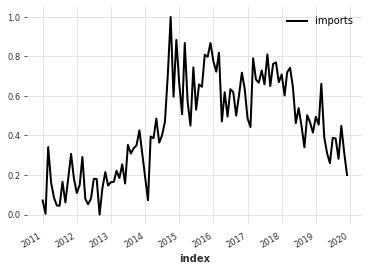

In [24]:
scaler_target, scaler_externos = Scaler(), Scaler()
target_scaled = scaler_target.fit_transform(target)
externos_scaled = scaler_externos.fit_transform(externos)

target_scaled.plot(label='imports')
plt.legend();


In [25]:
ntest = 92
trainTarget = target_scaled[:ntest]
trainExternas = externos_scaled[:ntest]
trainTarget

<TimeSeries (DataArray) (index: 92, component: 1, sample: 1)>
array([[[0.07077584]],

       [[0.00355408]],

       [[0.34165644]],

       [[0.16282054]],

       [[0.0871674 ]],

       [[0.04661414]],

       [[0.0442473 ]],

       [[0.16567443]],

       [[0.0614585 ]],

       [[0.18102162]],

...

       [[0.76948863]],

       [[0.66963202]],

       [[0.70845817]],

       [[0.60265639]],

       [[0.72046123]],

       [[0.74210774]],

       [[0.64482416]],

       [[0.46234236]],

       [[0.53865541]],

       [[0.44866276]]])
Coordinates:
  * index      (index) datetime64[ns] 2011-01-01 2011-02-01 ... 2018-08-01
  * component  (component) object '0'
Dimensions without coordinates: sample

In [26]:
trainExternas

<TimeSeries (DataArray) (Date: 92, component: 40, sample: 1)>
array([[[0.05192878],
        [0.0617284 ],
        [0.04316547],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.15281899],
        [0.06944444],
        [0.25179856],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.30118694],
        [0.16512346],
        [0.39328537],
        ...,
...
        ...,
        [0.        ],
        [1.        ],
        [0.        ]],

       [[0.92878338],
        [0.42901235],
        [0.94724221],
        ...,
        [0.        ],
        [1.        ],
        [0.        ]],

       [[0.90801187],
        [0.63734568],
        [0.93764988],
        ...,
        [0.        ],
        [1.        ],
        [0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2011-01-01 2011-02-01 ... 2018-08-01
  * component  (component) object 'UM Temperature' 'UM Precipitation' ... 'Fall'
Dimensions without coordinates: sample

In [27]:
# Entrenamiento multivariado
# RRN con pasado de exógenas

"""
"The length of both input (target and covariates) and output (target) time series
used during training. Generally speaking, training_length should have a higher value
than input_chunk_length because otherwise during training the RNN is never run for as 
many iterations as it will during training.
For more information on this parameter, please see darts.utils.data.ShiftedDataset"
"""
from darts.models import BlockRNNModel

#trainExternas = externos[:ntest]

model_cov = BlockRNNModel(model='GRU', input_chunk_length=12, 
                          output_chunk_length=16, n_epochs=1000,
                          random_state=0,dropout = 0.2 )


model_cov.fit(series=trainTarget,
              past_covariates=trainExternas,
              verbose=True)


[2021-11-11 09:06:55,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
[2021-11-11 09:06:55,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
C:\Users\Derevo\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
[2021-11-11 09:06:55,690] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-11 09:06:55,690] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Red Neuronal Recursiva MAPE: 74.18392717956937')

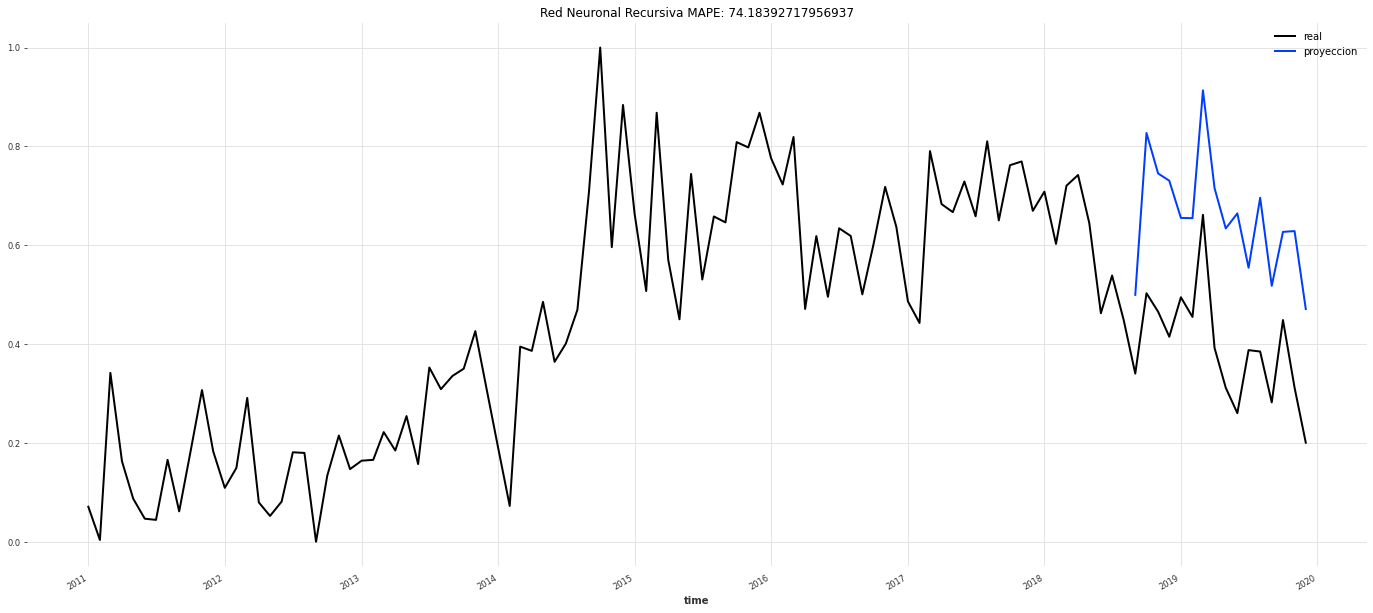

In [28]:
pred = model_cov.predict(n=16, series=target_scaled[:-16],past_covariates = externos_scaled[:-16] )

res_mape = mape(target_scaled, pred)

# Visualizar resultados
plt.figure(figsize=(24, 10))
target_scaled.plot(label='real')
pred.plot(label='proyeccion')
plt.title("Red Neuronal Recursiva MAPE: " + str(res_mape))



In [129]:
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    input_chunk_length=24,
    output_chunk_length=16,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood())

deeptcn.fit(series=trainTarget, past_covariates=trainExternas, verbose=True)

[2021-11-10 16:50:05,428] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53 samples.
[2021-11-10 16:50:05,428] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53 samples.
[2021-11-10 16:50:05,431] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2021-11-10 16:50:05,431] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2021-11-10 16:50:05,517] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-10 16:50:05,517] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/20 [00:00<?, ?it/s]

In [132]:
backtest_en = deeptcn.historical_forecasts(
    series=target_scaled,
    past_covariates=externos_scaled,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True)



res_mape = mape(target_scaled, backtest_en)

# Visualizar resultados
plt.figure(figsize=(24, 10))
target_scaled.plot(label='real')
backtest_en.plot(label='proyeccion')
plt.title("Red Neuronal Recursiva MAPE: " + str(res_mape))



  0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: The expanded size of the tensor (16) must match the existing size (14) at non-singleton dimension 1.  Target sizes: [32, 16, 40].  Tensor sizes: [32, 14, 40]